# House Prices: Advanced Regression Techniques + Insights with XAI

## Introduction

This project tackles the classic Kaggle regression problem: predicting house sale prices in Ames, Iowa, using a rich dataset of residential property features. 
The dataset includes 79 explanatory variables describing various aspects of residential homes, such as location, quality, size, and amenities.

**The pripary goal of this project is to intoduce XAI tehcniques, namely, SHAP Values.** 

**Objectives:**
- Explore and visualize the dataset to understand key features and relationships.
- Engineer and preprocess features to improve model performance.
- Build and tune advanced regression models (e.g., XGBoost) to accurately predict house prices.
- Evaluate model performance using appropriate metrics.
- Interpret model predictions using explainable AI technique: SHAP values.

# 1. Data Exploration

In [1]:
import pandas as pd 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) # to display all columns of the DataFrame

In [2]:
# Loading the datasets
test = pd.read_csv('/Users/asiljon/Desktop/Data Science Projects/Housing_prices/house-prices-advanced-regression-techniques/test.csv')
train = pd.read_csv('/Users/asiljon/Desktop/Data Science Projects/Housing_prices/house-prices-advanced-regression-techniques/train.csv')

In [3]:
# Getting overview of the datasets
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [50]:
# Checking missing values
display(train.isnull().sum().sort_values(ascending=False).head(20))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
MSSubClass         0
Fireplaces         0
dtype: int64

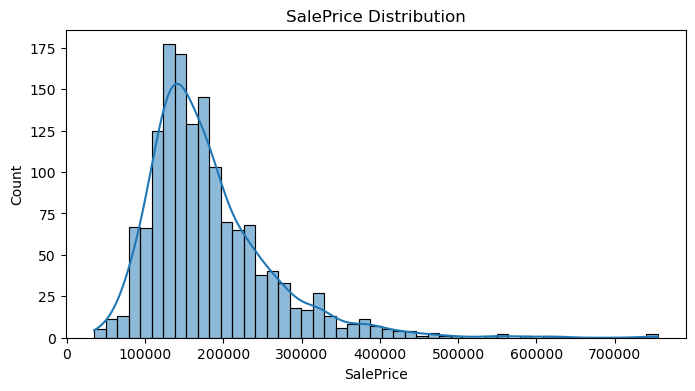

In [51]:
# Visualizing target variable distribution
plt.figure(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

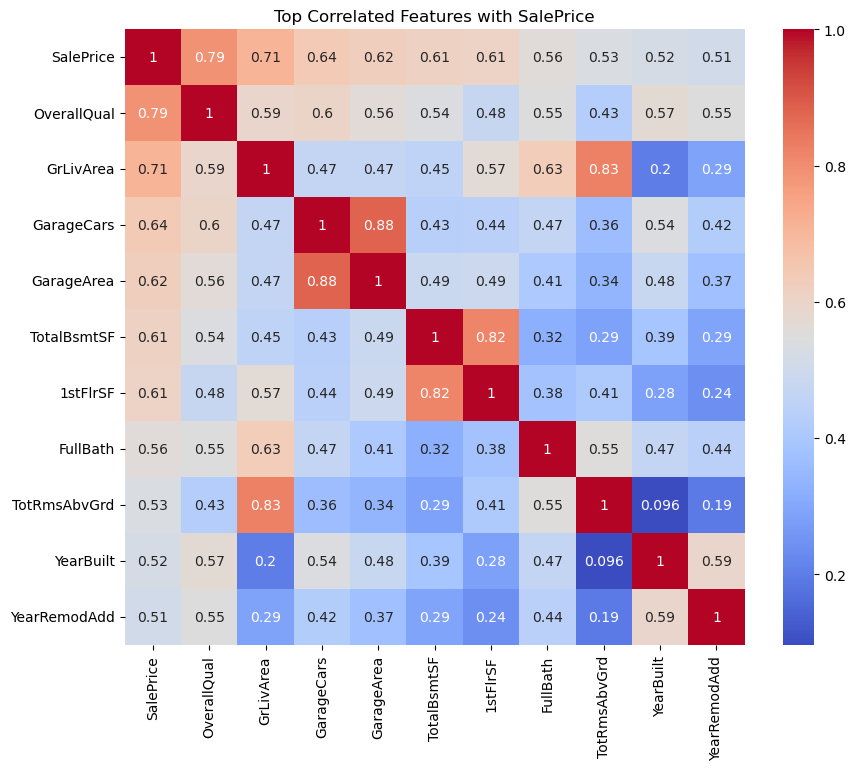

In [7]:
# Correlation heatmap (top 10 features)
plt.figure(figsize=(10,8))
corr = train.select_dtypes(include=[np.number]).corr()
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).head(11).index
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title('Top Correlated Features with SalePrice')
plt.show()

# 2. Feature Engineering and Data Preparation

In [8]:
# Setting ID as index to be able to get the ids later without dropping them form the DataFrame
train.set_index("Id", inplace=True)
test.set_index("Id", inplace=True)
test.head(5) # checking test set because it starts with 1461, not 0 like train set

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
# Converting categorical columns to 'category' dtype
cat_cols = [
    'MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope',
    'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
    'Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
    'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
    'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
    'MiscFeature','MoSold','YrSold','SaleType','SaleCondition'
]
for col in cat_cols:
    if col in train.columns:
        train[col] = train[col].astype('category')
    if col in test.columns:
        test[col] = test[col].astype('category')

In [10]:
# Filling missing values for GarageYrBlt
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0).astype(np.int64)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0).astype(np.int64)

# creating a new feature as time between YearRemodAdd and YearBuilt
train['to_renov'] = train['YearRemodAdd'] - train['YearBuilt']
test['to_renov'] = test['YearRemodAdd'] - test['YearBuilt']

In [11]:
# Fill missing values before casting
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0).astype(np.int64)
# creating a new feature 
test['to_renov'] = test['YearRemodAdd'] - test['YearBuilt']

In [12]:
# Splitting the dataset into features and target variable
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [13]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [18]:
model = xgb.XGBRegressor(enable_categorical=True)

In [44]:
# Searching for the best hyperparameters using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for random search
param_dist = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [3, 5, 7, 10, 15, 20, 30],
    'subsample': [0.3, 0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 1, 2, 4, 6, 8, 10],
    'reg_lambda': [0, 1, 2, 4, 6, 8, 10],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 3, 5, 7, 10]
}

xgb_random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Ensure all categorical columns are of 'category' dtype for XGBoost
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

xgb_random_search.fit(X_train, y_train)
print("Best parameters found:", xgb_random_search.best_params_)


Best parameters found: {'subsample': 0.3, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0}


In [45]:
#Training XGBRegressor with optimal hyperparameters
model = xgb.XGBRegressor(subsample=0.3, reg_lambda= 10, reg_alpha=2, n_estimators = 300, min_child_weight = 5, max_depth = 15, learning_rate = 0.03, gamma = 0.2, enable_categorical=True)

In [46]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
y_pred = model.predict(X_test)

In [48]:
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    # Avoid division by zero
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), epsilon))) * 100
print()

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


MAPE: 9.84%


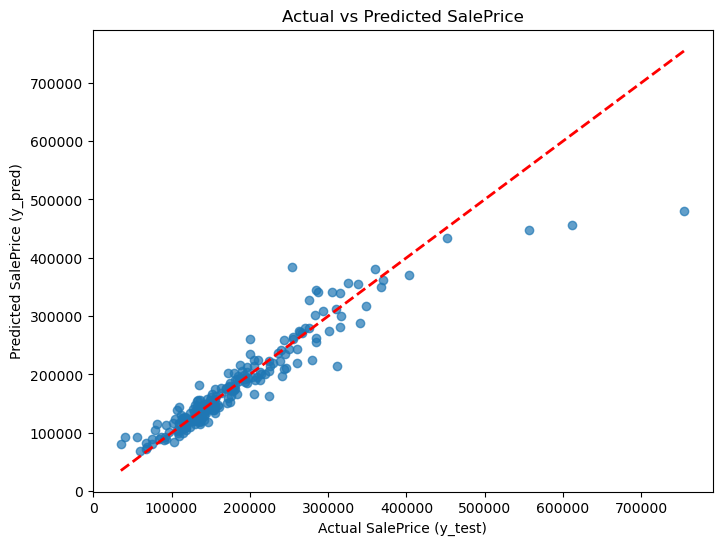

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual SalePrice (y_test)')
plt.ylabel('Predicted SalePrice (y_pred)')
plt.title('Actual vs Predicted SalePrice')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

In [24]:
# fitting the model on the entire training set
model.fit(X, y)
# Making predictions on the test set
test_pred = model.predict(test)

In [25]:
# preparing the submission DataFrame
test_pred = pd.DataFrame(test_pred)
test.reset_index(inplace=True)  # Reset index to get the 'Id' column back
submission = pd.merge(test, test_pred, left_index=True, right_index=True, how='left')
submission = submission.rename(columns={0: 'SalePrice'})
submission = submission[['Id', 'SalePrice']]
submission.to_csv('/Users/asiljon/Desktop/Data Science Projects/Housing_prices/house-prices-advanced-regression-techniques/submission.csv', index=False)
# Displaying the first few rows of the submission DataFrame
print(submission.head())


     Id      SalePrice
0  1461  130090.492188
1  1462  166355.937500
2  1463  186899.359375
3  1464  201892.656250
4  1465  191971.781250


# Applying Explainable Artificial Intelligence – SHAP Values

### Main goal of this section

Here, we use SHAP values to interpret our regression model—both globally and locally—to:
- Identify the most influential features for house prices.
- Understand individual predictions.
- Build trust and ensure the model aligns with domain knowledge.

### Why to use XAI methods like SHAP values?

Modern machine learning models can be highly accurate but often lack transparency. In fields like finance, healthcare, and real estate, understanding *why* a model makes certain predictions is essential for trust, fairness, and compliance.

They show how much each feature contributes to a single prediction by fairly distributing the "credit" (or "blame") among all features, based on game theory.

### How it works:

For each prediction, SHAP calculates the average contribution of each feature by considering all possible combinations of features.
The SHAP value for a feature tells you how much that feature increased or decreased the prediction compared to the average prediction.

**SHAP (SHapley Additive exPlanations) values** help interpret model predictions by showing how much each feature contributes to a specific prediction. This makes it easier to spot biases, validate model logic, and communicate results to stakeholders.

### It is also important to understand the difference between local and global explainability

- **Local Explainability:** Explains individual predictions (e.g., why a specific house was valued at a certain price).
- **Global Explainability:** Shows which features are most important overall for the model’s predictions.




### Let's start with global feature importance to get an overview of the model's feature importance

In [32]:
import shap
# Create SHAP explainer instance
explainer = shap.Explainer(model)

### Beeswarm – one of the most interesting global explanation vidualizations: 
- The SHAP "beeswarm" chart is a visualization that displays the distribution of SHAP values for each feature across all samples.
- Its main purpose is to show both the importance and the effect (direction and magnitude) of features on the model's predictions.
- In SHAP, the beeswarm plot helps users quickly identify which features have the most impact and how they influence the prediction (increase or decrease).

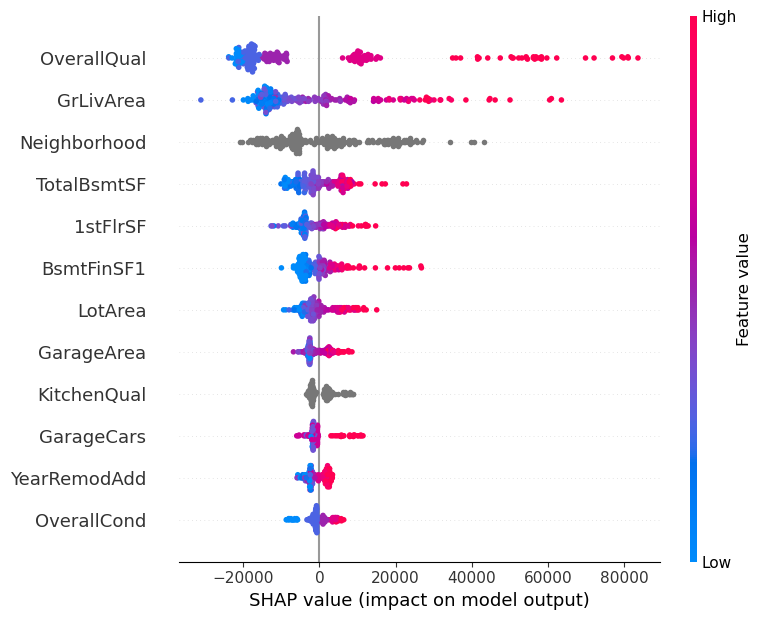

In [33]:
# Compute SHAP values
shap_values = explainer(X_test)
# Visualize summary plot
shap.summary_plot(shap_values, X_test, max_display=12)

**Insight 1:** Overall quality of the house (Overall material and finish quality) is the most important feature: the better the quality, the higher the price. However, only high values in overall quality increase the price, while low and moderate overall quality tend to have negative effect on the predicted price. In the far right case, this feature caused the model to add 80 000 USD to predicted price. 

**Insight 2:** GrLivArea (Above grade (ground) living area square feet) is the second most important feature. Higher area might indicate higher number of floors, which is supposed to increase the prices. That's exactly what we see in the chart. 

**Insight 3:** Neighborhood is the third morst important feature. It is a categorical feature. That is why we don't see colored scale of feature values. However, we can see that there is wide distribution of the effect on the predicted price. Perhaps, we can find more insights when we have a look at individual featues using scatter plots. 

**Insight 4:** Overall, we can observe that the model increses the predicted price mostly when the feature values are very high, as in the case of OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF, BsmtFinSF, LotArea, and GarageCars. 

**Note:** Categorical features are shown in grey because they do not have numerically scalable values. At least in this project. 

---

### The SHAP feature importance plot
The SHAP feature importance plot ranks features by their average impact on the model’s predictions. 

The longer the bar, the more influence that feature has on the output.

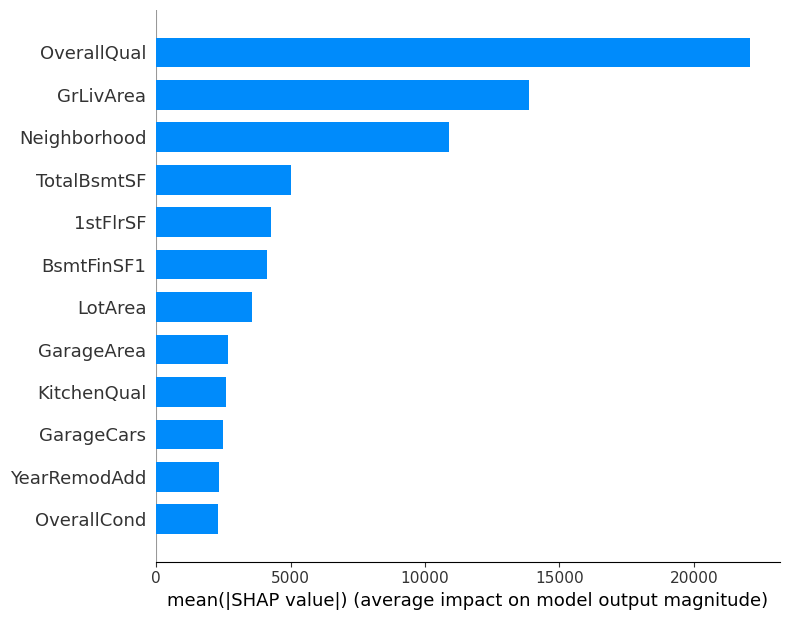

In [34]:
# Feature importance plot
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=12)

---

### Heatmap is another way to visualize global feature impact
The SHAP heatmap visualizes the SHAP values for all features and samples, showing how each feature contributes to each individual prediction. The color intensity indicates the strength and direction of the feature’s impact (red for higher, blue for lower).
This plot helps you quickly spot which features have the largest effects for specific predictions and identify patterns or outliers in model behavior.

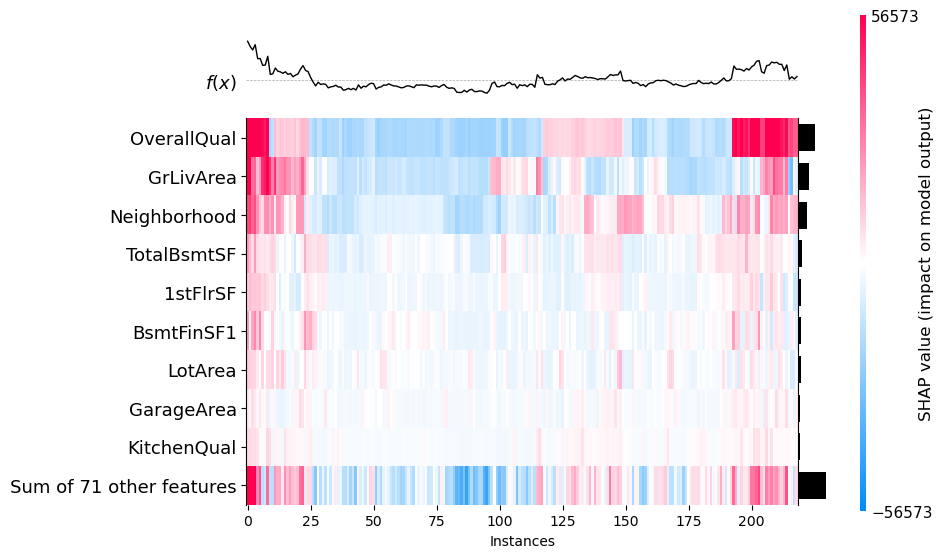

<Axes: xlabel='Instances'>

In [35]:
shap.plots.heatmap(shap_values)

---

### Now let's try some of the local feature importance plots

### The Waterfall – my favourite local explainability plot
The SHAP waterfall plot visualizes how each feature contributes to a single prediction, starting from the model’s average output. It shows which features push the prediction higher or lower, making it easy to understand the reasoning behind an individual prediction.

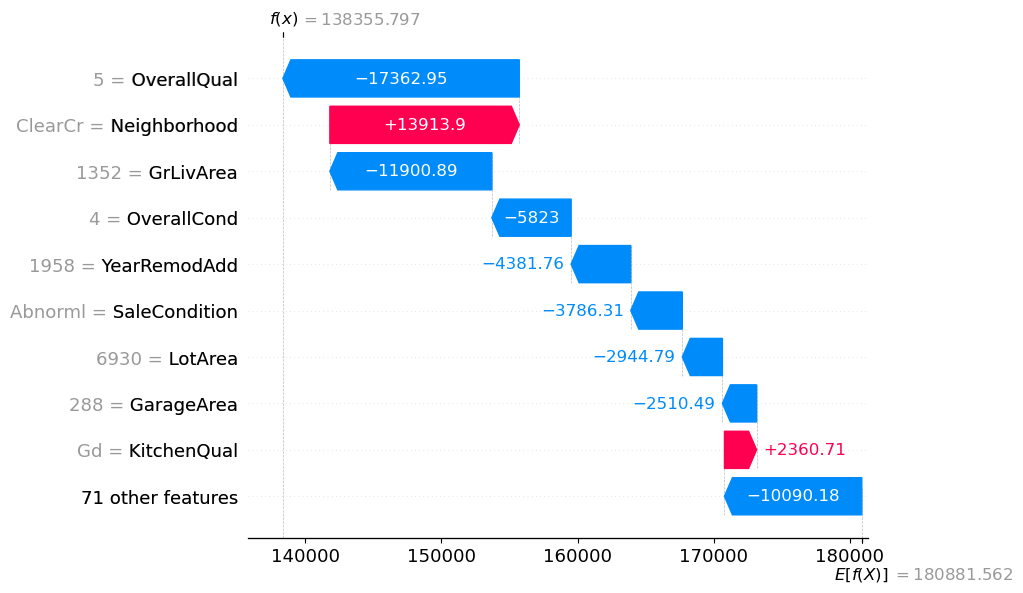

In [38]:
shap.plots.waterfall(shap_values[218])

**Insight:** This lot is not in very good condition, that is why for the majority of the features, the model decreased the predicted price. However it is located in very good neighborhood, that is why the price is increased. This increase almost compensated the price drop caused by Overall Quality of the house. 


---

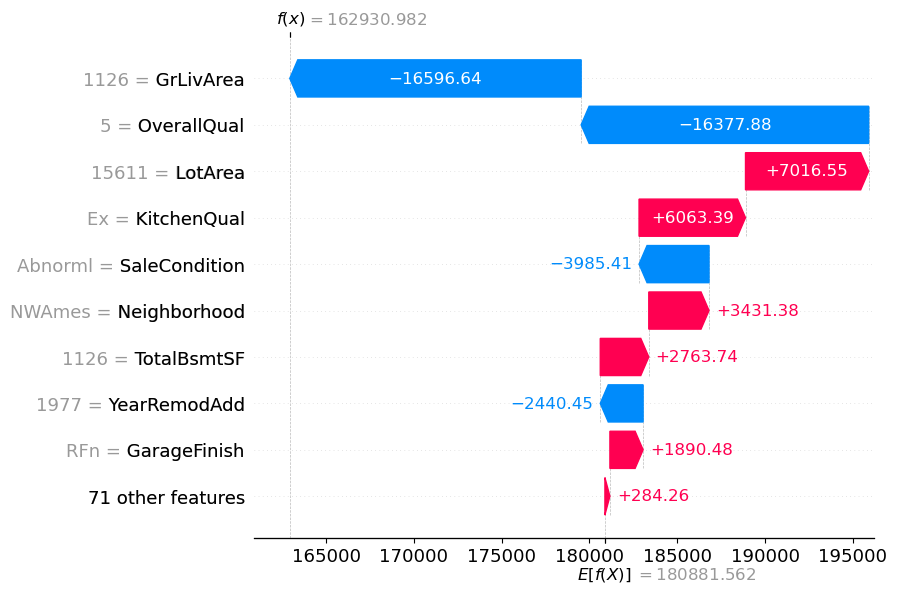

In [40]:
shap.plots.waterfall(shap_values[57])

**Insight:** This lot is interesting. For many of the features it has very good values, and, hense, they increase the predicted price. However, the Overall Quality and livivng area above ground are not so good, that is why the predicted price is below average. 

---

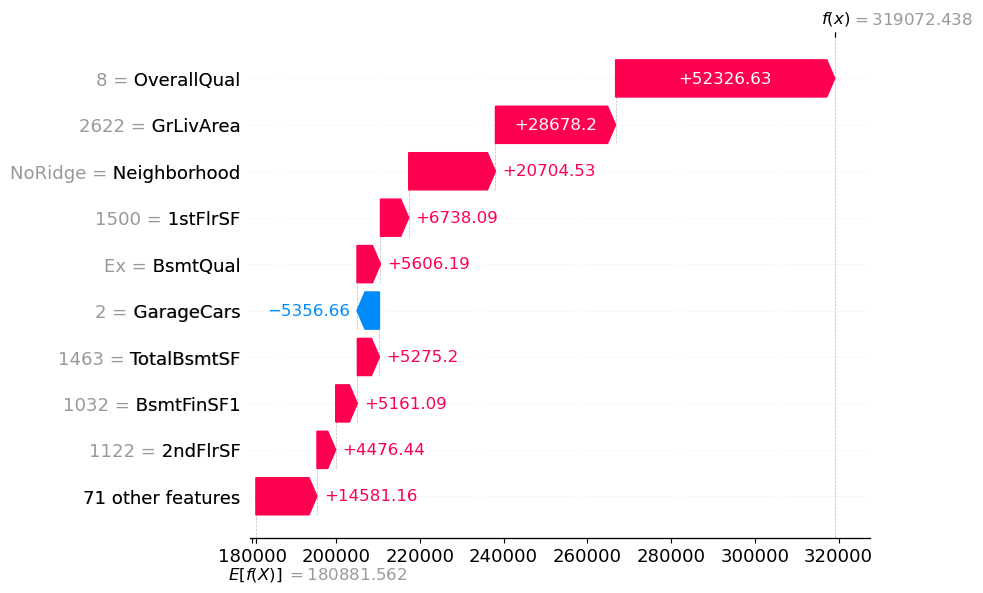

In [41]:
shap.plots.waterfall(shap_values[1])

**Insight:** This is a very good lot. Everything about it is great. But the garage is a bit small for a house of this size – it only fits 2 cars

---

### Scatter Plots can be used to observe feature interactions:
The following SHAP scatter plot shows how the SHAP values for GrLivArea (above or below zero) impact individual predictions, with each point representing a house. The color indicates the value of LotArea, helping you see how these two features interact. This plot helps you understand both the effect of GrLivArea and how its relationship with LotArea influences the model’s output for each prediction.

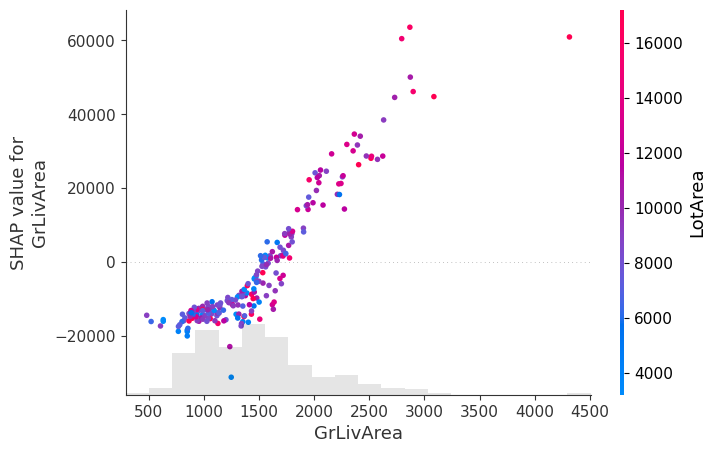

In [ ]:
shap.plots.scatter(shap_values[:,"GrLivArea"], color = shap_values[:,"LotArea"])

---

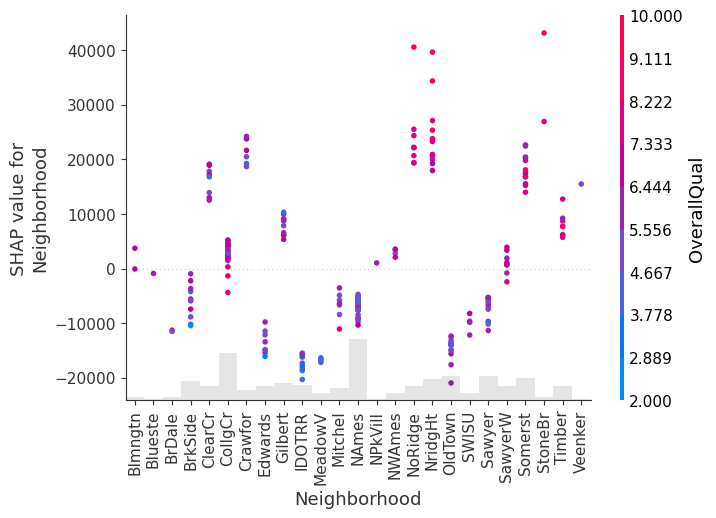

In [53]:
shap.plots.scatter(shap_values[:,"Neighborhood"], color = shap_values[:,"OverallQual"])

**Insight:** This plot shows us effect of each neighborhood on predicted price and color allows to see the overall quality of the houses. Noridge, NridgHt, and Somerst seem be very nice neighborhoods. All of the houses in these neighborhoods have quite high overall quality score and the model increases the prices for the houses located in these neighborhoods. We can make the same conclusions about StoneBr and Timber as well. 

---

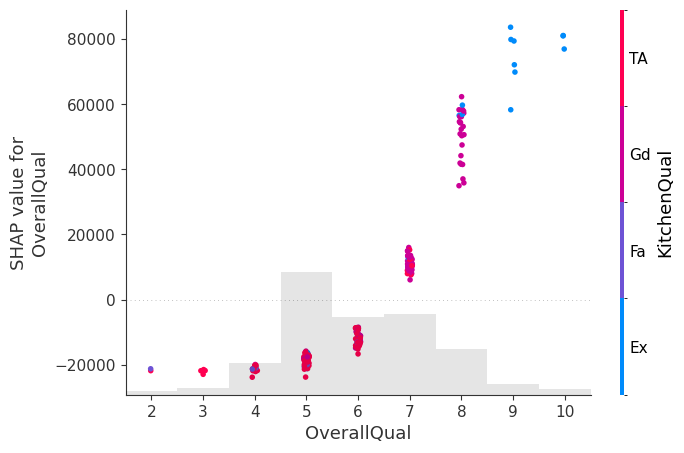

In [54]:
shap.plots.scatter(shap_values[:,"OverallQual"], color = shap_values[:,"KitchenQual"])

**Note:** Here is the description of Kitchen quality categories. The scale in the right side does not show the categories in order. 
- Ex – Excellent
- Gd – Good
- TA – Typical/Average
- Fa – Fair
- Po – Poor

**Insight 1:** Excellent kitchen quality is mostly in the houses with Overall Quality score of 8-10. Majority of the houses with Overall Quality score of  8 have 'Good' Kitchen Quality. 

**Insight 2:** The model adds the price to houses with Overall Quality of 7 and higher. 